In [1]:
import requests
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
data = yf.Ticker("^NSEI")
data = data.history(period="max")
data.to_csv("nifty50.csv")

data.index = pd.to_datetime(data.index)

In [3]:
# Use relevant features for stock data
data = data[['Close', 'Open', 'High', 'Low', 'Volume']]

# Create additional features like moving averages for trend analysis
data.loc[:, 'MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# Create the target variable to predict 3 months ahead (approx. 60 trading days)
data['Target'] = data['Close'].shift(-60)

# Drop rows with NaN values due to shifting
data.dropna(inplace=True)

# Create the target class (1 for price increase, 0 for price decrease)
data['Target_Class'] = (data['Target'] > data['Close']).astype(int)

# Drop unnecessary columns and target variable
data.drop(['Target'], axis=1, inplace=True)


In [4]:
# Perform train-test split
X = data.drop(['Target_Class'], axis=1)
y = data['Target_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and retrain the model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(n_estimators=200, random_state=42)

In [5]:
# Make predictions and evaluate model performance
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


In [6]:
# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       278
           1       0.82      0.85      0.84       545

    accuracy                           0.78       823
   macro avg       0.75      0.74      0.75       823
weighted avg       0.78      0.78      0.78       823



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


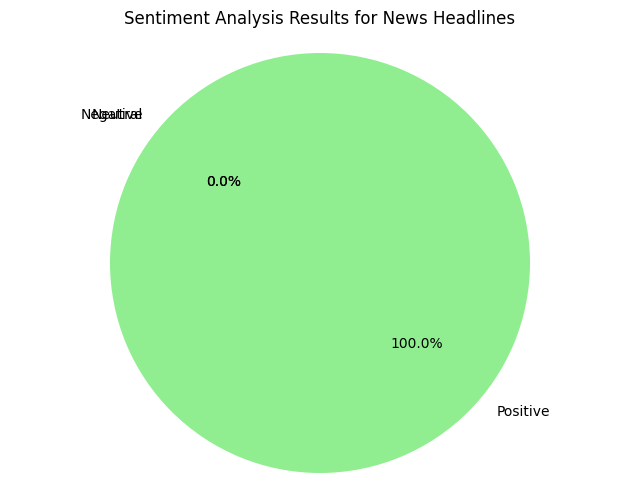

In [7]:
import requests
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

# Marketaux API key (replace with your actual key)
API_KEY = "mYwVybhtwmbSWfWBH4f7HB3C7QYh3GN9OJwq6ucW"
STOCK_SYMBOL = "NSEI"

# Fetch news from Marketaux API
def fetch_news(stock_symbol):
    url = f"https://api.marketaux.com/v1/news/all?symbols={stock_symbol}&filter_entities=true&api_token={API_KEY}"
    response = requests.get(url)
    news_data = response.json()

    if "data" in news_data:
        return [article['title'] for article in news_data['data']]
    else:
        raise Exception("Failed to retrieve news data")

# Initialize VADER for sentiment analysis
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Fetch news headlines for the stock symbol
news_headlines = fetch_news(STOCK_SYMBOL)

# Perform sentiment analysis on each headline and combine scores
sentiments = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
scores_list = []  # List to collect individual scores for pie chart

for headline in news_headlines:
    scores = sid.polarity_scores(headline)  # Get sentiment scores for the headline
    compound_score = scores['compound']

    # Classify the sentiment based on the compound score
    if compound_score >= 0.05:
        sentiment = "Positive"
    elif compound_score <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    sentiments[sentiment] += 1
    scores_list.append(scores)  # Store the individual scores

# Determine overall sentiment based on most frequent classification
overall_sentiment = max(sentiments, key=sentiments.get)

# Calculate sizes for pie chart
sizes = [sentiments['Positive'], sentiments['Negative'], sentiments['Neutral']]

# Optional: Ensure that at least one of the sentiment scores is non-zero
if sum(sizes) == 0:
    sizes = [1, 0, 0]

# Labels and colors for the pie chart
labels = ['Positive', 'Negative', 'Neutral']
colors = ['lightgreen', 'lightcoral', 'skyblue']

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis Results for News Headlines')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [8]:

# Combine Random Forest stock prediction and sentiment analysis for recommendation
# Use the last available stock features to make future predictions (Assume `X` is the feature DataFrame and `model` is trained)
future_features = X.iloc[-1, :].to_frame().T
future_prediction = model.predict(future_features)


# Output recommendation based on the combination of stock prediction and sentiment analysis
if future_prediction == 1 and overall_sentiment == "Positive":
    recommendation = "Strong Buy"
elif future_prediction == 1 and overall_sentiment == "Neutral":
    recommendation = "Buy"
elif future_prediction == 1 and overall_sentiment == "Negative":
    recommendation = "Cautious Buy"
elif future_prediction == 0 and overall_sentiment == "Positive":
    recommendation = "Hold"
else:
    recommendation = "Do not Buy"

In [9]:
# Output final recommendation
print("\nStock Movement Prediction:", "Up" if future_prediction == 1 else "Down")
print("Sentiment Analysis:", overall_sentiment)
print(f"Final Recommendation: {recommendation}")


Stock Movement Prediction: Up
Sentiment Analysis: Positive
Final Recommendation: Strong Buy


In [10]:
# Print sentiment analysis result
print("\nSentiment Analysis Result:")
print(f"Overall sentiment: {overall_sentiment}")



Sentiment Analysis Result:
Overall sentiment: Positive


In [11]:
from sklearn.metrics import precision_score

# After making predictions on the test set
y_pred = model.predict(X_test)

# Calculate the precision score
precision = precision_score(y_test, y_pred)

print(f"Precision Score: {precision:.2f}")


Precision Score: 0.82
